**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.


## Mengimpor Libraries yang dibutuhkan


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

!nvidia-smi




Num GPUs Available:  1
Thu Aug 31 17:33:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              N/A / ERR! |   2258MiB /  3072MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## Preprocessing Datasets


In [14]:
from PIL import Image
from imutils import paths
import os
INIT_LR = 1e-4
EPOCHS = 100
BS = 32

# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images("dataset_small"))  # Dataset Penelitian
data = []
labels = []

# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)

# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...
Input gambar berhasil


### Membuat objek ImageDataGenerator dan Data Augmentation


In [15]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 80% : 20% )

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=42)

# Membentuk training image generator untuk data augmentation

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [16]:
# Melihat jumlah data dalam set pelatihan
num_train_samples = trainX.shape[0]
print("Jumlah data pelatihan:", num_train_samples, " Citra")

# Melihat jumlah data dalam set pengujian
num_test_samples = testX.shape[0]
print("Jumlah data pengujian:", num_test_samples, " Citra")

Jumlah data pelatihan: 1120  Citra
Jumlah data pengujian: 480  Citra


## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)


In [17]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
# baseModel = tf.keras.applications.VGG16(include_top=False, input_tensor=Input(shape=(224, 224, 3)))


### Feature Extraction


In [18]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model


In [19]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [20]:

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False

# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)


model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 

### Melakukan Pelatihan Model


In [21]:
import time

# ...

print("Training head model...")

start_time = time.time()  # Memulai penghitungan waktu

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose=1)

end_time = time.time()  # Mengakhiri penghitungan waktu
training_duration = end_time - start_time  # Menghitung durasi waktu pelatihan dalam detik

# ...

print(f"Training completed in {training_duration:.2f} seconds.")  # Menampilkan durasi waktu pelatihan


Training head model...
Epoch 1/100
35/35 [==============================] - 19s 497ms/step - loss: 0.8263 - accuracy: 0.4964 - val_loss: 0.7824 - val_accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 17s 470ms/step - loss: 0.8193 - accuracy: 0.5000 - val_loss: 0.7728 - val_accuracy: 0.5000
Epoch 3/100
35/35 [==============================] - 17s 481ms/step - loss: 0.8010 - accuracy: 0.4893 - val_loss: 0.7641 - val_accuracy: 0.5000
Epoch 4/100
35/35 [==============================] - 17s 480ms/step - loss: 0.7949 - accuracy: 0.4982 - val_loss: 0.7559 - val_accuracy: 0.5000
Epoch 5/100
35/35 [==============================] - 17s 486ms/step - loss: 0.7794 - accuracy: 0.4938 - val_loss: 0.7491 - val_accuracy: 0.5000
Epoch 6/100
35/35 [==============================] - 17s 491ms/step - loss: 0.7796 - accuracy: 0.5098 - val_loss: 0.7424 - val_accuracy: 0.5000
Epoch 7/100
35/35 [==============================] - 18s 496ms/step - loss: 0.7785 - accuracy: 0.4893 - val_loss:

## Menampilkan Grafik Model Hasil Pelatihan


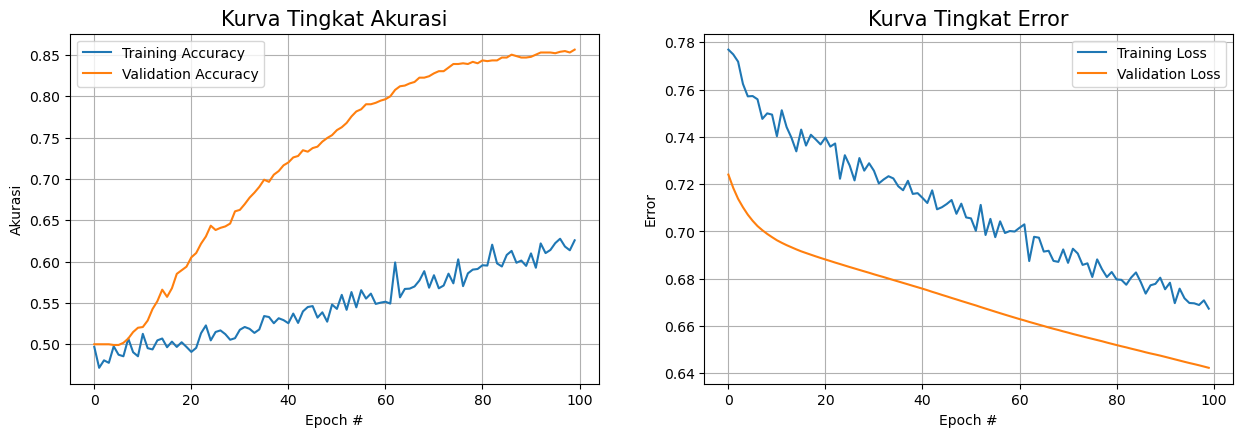

In [ ]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"], label="Training Accuracy")
plt.plot(np.arange(0, N),
         H.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder=0)

plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder=0)
plt.show()

## Evaluasi Jaringan


In [ ]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
'''
print(model.evaluate(x= testX, y = testY))
'''

print(model.evaluate(x=testX, y=testY))
# evaluasi fold

['loss', 'accuracy']


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

15/15 [==============================] - 5s 336ms/step
[0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0
 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0
 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0
 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1
 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1
 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 0
 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0
 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0
 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 

## Confusion Matrix


In [ ]:

def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue))
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[230,  10],
       [  0, 240]])

Text(0.5, 23.52222222222222, 'Label Prediksi')

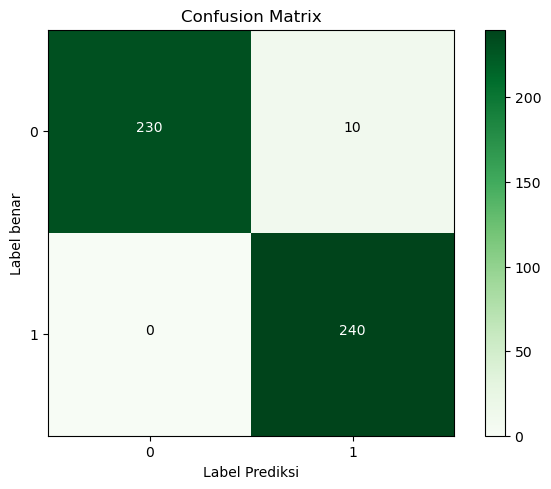

In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

Analisis mAP


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# menghitung nilai accuracy
accuracy = accuracy_score(yTrue, yPred)

# Menghitung nilai recall
recall = recall_score(yTrue, yPred)

# Menghitung nilai presisi
precision = precision_score(yTrue, yPred)

# Menghitung nilai F1-Score
f1 = f1_score(yTrue, yPred)

print("Akurasi:", accuracy)
print("Recall:", recall)
print("Presisi:", precision)
print("F1-Score:", f1)

Akurasi: 0.9791666666666666
Recall: 1.0
Presisi: 0.96
F1-Score: 0.9795918367346939


In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)

# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)

# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

15/15 [==============================] - 4s 270ms/step
              precision    recall  f1-score   support

   with_mask       1.00      0.96      0.98       240
without_mask       0.96      1.00      0.98       240

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



## Menyimpan dan Konversi Model ke ".tflite"

Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.


# Pengujian Model dengan MTCNN


Model diujikan pada gambar dan secara real-time dengan menggunakan MTCNN yang digunakan untuk mendeteksi wajah.


## Penggunaan Model pada Gambar


## Pengujian Deteksi Perframe Capture


## Pengujian Streaming Video
